# Capstone Project - The Battle of the Neighborhoods (FINAL)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Ramen/Sushi Restaurant** in **Manhattan**, New York.

Since there are lots of restaurants in Berlin we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no Ramen/Sushi restaurants in nearby**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.


## Data <a name="data"></a>

### What data is used and how will the problem be solved?
Based on definition of our problem, factors that will influence our decision are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of to Ramen/Sushi restaurants in the neighborhood, if any

We will be completely working on Foursquare data to explore and try to locate a spot for our new ramen/sushi restaurant, as stated before, at a location that is not already crowded with similar restaurants. We will examine each neighborhood in the area of interest, and using the Foursquare API, we will explore nearby venues. In particular, we are interested in the grabbing ramen or sushi to eat.

### Importing Libraries

In [1]:
# Import libraries
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

#!pip install geocoder
import geocoder

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

from bs4 import BeautifulSoup # scraping library

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### Importing NY Neighborhood Data

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']

In [3]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [4]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Manhattan.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent foursquare_agent, as shown below.

In [6]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

Man='Manhattan geograpical coordinate: {},{}'.format(latitude,longitude)

print(Man)

Manhattan geograpical coordinate: 40.7896239,-73.9598939


In [7]:
manhattan_df = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [8]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_df['Latitude'], manhattan_df['Longitude'], manhattan_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

When we explore the venues near each neighborhood so we can segment them, we are going to begin by returning the top 100 venues nearby, within a 1000 meter radius. We will then later filter this data to only display results regarding nearby sushi and ramen restaurants.

### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'

### Search for a Ramen and Sushi Restaurants within 2 KM Radius
#### Since we're looking in Manhattan NY, let's find out if there is any ramen and sushi spots within 2 KM

In [10]:
search_query_ramen = 'Ramen'
search_query_sushi = 'Sushi'

radius = 5000
LIMIT = 100
print(search_query_ramen + ' .... OK!')
print(search_query_sushi + ' .... OK!')

Ramen .... OK!
Sushi .... OK!


#### Define the corresponding URL

In [11]:
url_ramen = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_ramen, radius, LIMIT)
url_sushi = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_sushi, radius, LIMIT)

#### Send the GET Request and examine the results

In [12]:
results_ramen = requests.get(url_ramen).json()
results_sushi = requests.get(url_sushi).json()

#### Get relevant part of JSON and transform it into a pandas dataframe

In [13]:
# assign relevant part of JSON to venues
venues_ramen = results_ramen['response']['venues']
venues_sushi = results_sushi['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_ramen = pd.json_normalize(venues_ramen)
dataframe_sushi = pd.json_normalize(venues_sushi)

dataframe = pd.concat([dataframe_ramen,dataframe_sushi])

print("There are {} Ramen and Sushi Restaurants in Manhattan".format(dataframe.shape[0]))

There are 100 Ramen and Sushi Restaurants in Manhattan


#### Define information of interest and filter dataframe

In [14]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
df=dataframe_filtered[['name','categories','lat','lng','distance']]
df.head(10)

,name,categories,lat,lng,distance
0,Jin Ramen,Ramen Restaurant,40.785261,-73.976839,1508
1,Kitakata Ramen Ban Nai,Ramen Restaurant,40.778841,-73.981183,2158
2,Totto Ramen,Ramen Restaurant,40.765176,-73.990950,3776
3,Zurutto Ramen & Gyoza Bar,Ramen Restaurant,40.778068,-73.980390,2153
4,Nishida Shoten Ramen,Ramen Restaurant,40.754123,-73.968698,4021
5,Genji Ramen,Ramen Restaurant,40.824638,-73.974085,4077
6,Totto Ramen,Ramen Restaurant,40.764490,-73.987514,3639
7,Bua Thai Ramen & Robata Grill,Thai Restaurant,40.776350,-73.953080,1585
8,TORIBRO Ramen,Ramen Restaurant,40.764480,-73.987560,3643
9,E.A.K. Ramen,Ramen Restaurant,40.760659,-73.989999,4103


#### Let's visualize the ramen and sushi spots that are nearby

In [15]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Dallas

# add a red circle marker to represent the center of Manhattan, NY
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Manhattan',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the ramen/sushi restaurants as blue circle markers
for lat, lng, label in zip(df.lat, df.lng, df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
# display map
venues_map

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_df['Neighborhood'],
                                   latitudes=manhattan_df['Latitude'],
                                   longitudes=manhattan_df['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [18]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3225, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


Let's check how many venues were returned for each neighborhood

In [19]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,82,82,82,82,82,82
Carnegie Hill,90,90,90,90,90,90
Central Harlem,48,48,48,48,48,48
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,39,39,39,39,39,39
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [20]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 329 uniques categories.


### Lets analyze each neighborhood

In [21]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Peruvian Roast Chicken Joint,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social 

In [22]:
manhattan_onehot.shape

(3225, 330)

# Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Manhattan that have low restaurant density, particularly those with low number of Ramen and Sushi restaurants. We will limit our analysis to area ~5km around city center.

In the first step, we have collected the required data about **the location of each neighborhood and the type(category) of the venues within 5 km from the center of Manhattan**. We also **identified all the Ramen and Sushi restaurants** in the area (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**restaurant frequency**' across different areas of Manhattan. 

In third and final step we we used **K-Means Clustering to create clusters of locations that meet our criteria** as previous discussed in the inital introduction of the data. We then created a map of those clusters to better visualize the data and explore the best location for the investors.

# Analysis <a name="analysis"></a>

In [23]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Peruvian Roast Chicken Joint,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social 

Let us get only the data of interest from our current data set. We will filter our data to display only the neighborhood name and the frequency of ramen and sushi restaurants around that neighborhood.

In [24]:
df_ramensushi=manhattan_grouped[['Neighborhood','Sushi Restaurant','Ramen Restaurant']]
df_ramensushi.head()

,Neighborhood,Sushi Restaurant,Ramen Restaurant
0,Battery Park City,0.000000,0.000000
1,Carnegie Hill,0.022222,0.011111
2,Central Harlem,0.000000,0.000000
3,Chelsea,0.020000,0.000000
4,Chinatown,0.000000,0.010000


Before we can perform K-Means clustering, we must choose the optimal value of K.

In [25]:
manhattan_clustering=df_ramensushi.drop(['Neighborhood'],axis=1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(manhattan_clustering)
    distortions.append(kmeanModel.inertia_)


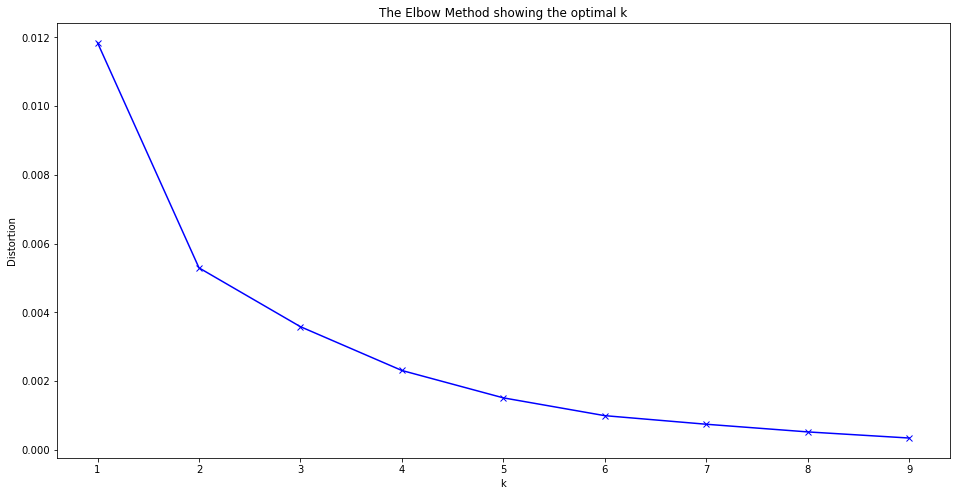

In [26]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the elbow method, the best value for K is K=2. Now we will perform K means clustering to segment the neighborhood into 2 clusters.

In [27]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0])

Let's create a new dataframe that includes the assigned cluster number as well as the borough name, neighborhood name as well as latitude and longitude, and the frequency of ramen and sushi restaurants. We will do this by merging two of our existing dataframes, df_ramensushi and df.

In [28]:
df.rename(columns={'Neighborhood':'Neighborhood'},inplace=True)
# add clustering labels
df_ramensushi.insert(0, 'cluster number', kmeans.labels_)

df_labeledclusters=pd.merge(df_ramensushi,manhattan_df, how='left',left_on='Neighborhood',right_on='Neighborhood')

df_labeledclusters.head()

C:\Users\harri\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,cluster number,Neighborhood,Sushi Restaurant,Ramen Restaurant,Borough,Latitude,Longitude
0,0,Battery Park City,0.000000,0.000000,Manhattan,40.711932,-74.016869
1,1,Carnegie Hill,0.022222,0.011111,Manhattan,40.782683,-73.953256
2,0,Central Harlem,0.000000,0.000000,Manhattan,40.815976,-73.943211
3,1,Chelsea,0.020000,0.000000,Manhattan,40.744035,-74.003116
4,0,Chinatown,0.000000,0.010000,Manhattan,40.715618,-73.994279


Finally, let's visualize the resulting clusters once again using folium.

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_labeledclusters['Latitude'],df_labeledclusters['Longitude'], df_labeledclusters['Neighborhood'], df_labeledclusters['cluster number']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### Cluster 1


In [30]:
#Cluster 1
df_labeledclusters.loc[df_labeledclusters['cluster number']==0]

,cluster number,Neighborhood,Sushi Restaurant,Ramen Restaurant,Borough,Latitude,Longitude
0,0,Battery Park City,0.000000,0.000000,Manhattan,40.711932,-74.016869
2,0,Central Harlem,0.000000,0.000000,Manhattan,40.815976,-73.943211
4,0,Chinatown,0.000000,0.010000,Manhattan,40.715618,-73.994279
6,0,Clinton,0.000000,0.000000,Manhattan,40.759101,-73.996119
7,0,East Harlem,0.000000,0.000000,Manhattan,40.792249,-73.944182
8,0,East Village,0.000000,0.020000,Manhattan,40.727847,-73.982226
9,0,Financial District,0.000000,0.000000,Manhattan,40.707107,-74.010665
10,0,Flatiron,0.010000,0.000000,Manhattan,40.739673,-73.990947
11,0,Gramercy,0.011111,0.000000,Manhattan,40.737210,-73.981376
14,0,Hudson Yards,0.000000,0.000000,Manhattan,40.756658,-74.000111


In [31]:
#Cluster 2
df_labeledclusters.loc[df_labeledclusters['cluster number']==1]

,cluster number,Neighborhood,Sushi Restaurant,Ramen Restaurant,Borough,Latitude,Longitude
1,1,Carnegie Hill,0.022222,0.011111,Manhattan,40.782683,-73.953256
3,1,Chelsea,0.020000,0.000000,Manhattan,40.744035,-74.003116
5,1,Civic Center,0.020000,0.000000,Manhattan,40.715229,-74.005415
12,1,Greenwich Village,0.050000,0.010000,Manhattan,40.726933,-73.999914
13,1,Hamilton Heights,0.032258,0.000000,Manhattan,40.823604,-73.949688
16,1,Lenox Hill,0.040000,0.000000,Manhattan,40.768113,-73.958860
21,1,Manhattanville,0.021277,0.021277,Manhattan,40.816934,-73.957385
23,1,Midtown,0.020000,0.000000,Manhattan,40.754691,-73.981669
26,1,Murray Hill,0.020000,0.010000,Manhattan,40.748303,-73.978332
27,1,Noho,0.030000,0.000000,Manhattan,40.723259,-73.988434


# Results and Discussion <a name="results"></a>

Based on the our cluseter analysis, we find that even though there are many ramen and sushi restaurants there are definitely a couple of neighborhoods that do not have any of these restaurants in the vicinity. The main were on the two specific restaurants near each neighborhood- ramen and sushi. We used specifically kmeans for this project. 

To recap, we predominantly focused on the Manhattan area of New York within a 2km radius. With this we were able to narrow it down the neighborhoods to the many locations that are marked under cluster 1. This group is predominantly the neighborhoods that does not have either ramen or sushi restaraunts. While cluster 2 has a higher frequency of both types of restaurants. More specifically we would probably determine the south side of Manhattan to be the optimal area for opening a ramen/sushi restaurant.

Also the down side of this analysis would be the reliance on the Foursquare API. It has a lot of informaiton saved but it doesn't help give more insight on other factors an investor should consider. It helps with locaiton but not exactly with for instance property overhead, proximity to major roads and highways, or socio/economic status of each neighborhood. 

# Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the Manhattan area close to center with low number of restaurants (particularly Ramen and Sushi restaurants) in order to aid stakeholders in narrowing down the search for optimal location for opening the restaurant. Calculating the frequency of the ramen/sushi restaurants with the help of data from Foursquare, helped us determine what neighborhoods meet our criteria. Clustering helped us determine what zones are of interest to help create a starting point on where the ideal location would be. 

With that being said, the final decision is ultimately up to the stakeholders on where to open up the new restaurant based on the analysis we provided. Location is very important but I still do believe other factors are just as important.